# Dirichlet-Multinomial Regression

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy.random as npr
from numpy import exp as exp
from numpy import log as log
from numpy import sqrt as sqrt
npr.seed(125)

from scipy.special import gammaln
from scipy.special import gamma

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 6.5, 4.5

# Generate Data

In [3]:
num_cov = 2 # number of covariates (including intercept)
num_doc = 1000 # number of documents
avg_doclen = 200 # average doc length
dim_dir = 3 # dimension of dirichlet
sigma = 1 # for lambda

In [4]:
# Generate Covariates
X = npr.normal(0, 1, size=(num_doc, num_cov))
X[:, 0] = 1 # intercept term

# Generate Lambda
Lambda = npr.normal(0, sigma, size=(dim_dir, num_cov))

# Convert it to alpha
Alpha = exp(X @ Lambda.transpose()) 

# Generate Theta
Theta = np.array([npr.dirichlet(Alpha[i]) for i in range(num_doc)])
Theta = Theta + 0.000001 # Don't make (nearly) 0 probability
Theta = Theta / Theta.sum(axis=1).reshape(num_doc, 1)

# Generate Z
docs_len = npr.poisson(avg_doclen, size=num_doc)
n_dz = np.array([npr.multinomial(docs_len[i], Theta[i]) for i in range(num_doc)])

In [5]:
#n_dz

# Log-Likelihood Function

Mimno and McCallum, 2008, "Topic Models Conditioned on Arbitrary Features with Dirichlet-multinomial Regression"

Eq.(2)
$$
\begin{align}
p(\mathbf{z}, \boldsymbol{\lambda}) &= \prod_d \frac{\Gamma(\sum_t \exp(\mathbf{x}_d^T \boldsymbol{\lambda}_t) )}{\Gamma( \sum_t \exp(\mathbf{x}_d^T \boldsymbol{\lambda}_t) + n_d)} \prod_t \frac{\Gamma(\exp(\mathbf{x}_d^T \boldsymbol{\lambda}_t) + n_{dt})}{\Gamma (\exp(\mathbf{x}_d^T \boldsymbol{\lambda}_t))} \times \prod_{t,k} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{\lambda_{tk}^2}{2 \sigma^2} \right)
\end{align}
$$

```latex
\begin{align}
p(\mathbf{z}, \boldsymbol{\lambda}) &= \prod_d \frac{\Gamma(\sum_t \exp(\mathbf{x}_d^T \boldsymbol{\lambda}_t) )}{\Gamma( \sum_t \exp(\mathbf{x}_d^T \boldsymbol{\lambda}_t) + n_d)} \prod_t \frac{\Gamma(\exp(\mathbf{x}_d^T \boldsymbol{\lambda}_t) + n_{dt})}{\Gamma (\exp(\mathbf{x}_d^T \boldsymbol{\lambda}_t))} \times \prod_{t,k} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{\lambda_{tk}^2}{2 \sigma^2} \right)
\end{align}
```

In [6]:
def calc_llk(Lambda, Theta, X):
    llk = 0.0
    alpha_d = exp(X @ Lambda.transpose())
    
    llk += gammaln(alpha_d.sum(axis=1)) # calc by document
    llk -=  gammaln(alpha_d.sum(axis=1) + docs_len) # calc by document
    
    llk = llk.sum() + ( gammaln(alpha_d + n_dz) - gammaln(alpha_d) ).sum()
    
    llk = llk.sum() + (  - Lambda**2 / (2*sigma**2)  -  0.5*log(2 * np.pi * sigma**2) ).sum()
    
    return llk

# Unbounded Slice Sampling

In [7]:
def expand(p, A=1):
    # p --> x
    return -(1/A) * np.log((1/p) - 1)
    
def shrink(x, A=1):
    # x --> p
    return 1 / (1 + np.exp(-A * x) )

In [8]:
Lambda_sample = npr.normal(0, 1, size=(dim_dir, num_cov))

In [9]:
num_sampling = 1000
max_shring_time = 1000
A = 1
sampled_values = np.zeros((num_sampling, dim_dir, num_cov))

for i in range(num_sampling):
    dim_vec = np.arange(dim_dir)
    npr.shuffle(dim_vec)
    
    for dim in dim_vec:
        cov_vec = np.arange(num_cov)
        npr.shuffle(cov_vec)
        
        for cov in cov_vec:
            start = 0.0
            end = 1.0
            
            old_value = Lambda_sample[dim, cov]
            previous_p = shrink(old_value)
            slice_ = calc_llk(Lambda_sample, Theta, X) -\
                    log(A*previous_p * (1-previous_p)) + log(npr.uniform())
            
            for shrink_time in range(max_shring_time):
                new_p = npr.uniform(start, end)
                proposal_value = expand(new_p, A)
                Lambda_sample[dim, cov] = proposal_value
                
                new_llk = calc_llk(Lambda_sample, Theta, X) - log( A * new_p * (1 - new_p) )
                
                if slice_ < new_llk:
                    use_value = proposal_value
                    break
                elif previous_p < new_p:
                    end = new_p
                elif new_p < previous_p:
                    start = new_p
                else:
                    print("Shrinked heavily")
                    use_value = old_value
                    break
                    
            sampled_values[i, dim, cov] = use_value
            Lambda_sample[dim, cov] = use_value           

In [10]:
# Mean Squared Error
Lambda_sampled_mean = sampled_values[max(0, int(num_sampling*0.7)): , :, :].mean(axis=0)
((Lambda_sampled_mean - Lambda)**2).mean()

0.0012504814422108995

In [11]:
def figure(dim, cov):
    plt.figure()
    truth = Lambda[dim, cov]
    sampled = sampled_values[max(0, int(num_sampling*0.7)): , dim, cov]
    
    f = sns.distplot(sampled, hist=True, kde=False)
    f.axvline(x=truth, linewidth=2.5, color = 'red')
    
    mean = sampled.mean(axis=0)
    
    f.axvline(x=mean, linewidth=2.5, color = 'green')
    
    xmin, xmax = f.get_xlim()
    
    f.text(xmax+0.01, 15, "Dim: " + str(dim) + " / Cov: " + str(cov),\
          ha ='left', fontsize = 15)
    
    f.text(xmax+0.01, 11, "Truth: " + str(round(truth,3)),\
           ha ='left', fontsize = 15, color = 'red')
    f.text(xmax+0.01, 7, "Sampled Mean: " + str(round(mean,3)),\
           ha ='left', fontsize = 15, color = 'green')
    
    f.text(xmax+0.01, 3, "Abs Diff: " + str(round(abs(truth-mean),3)),\
           ha ='left', fontsize = 15)

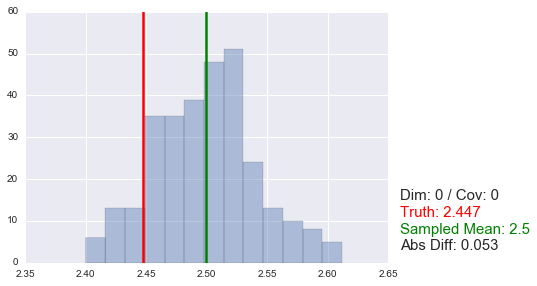

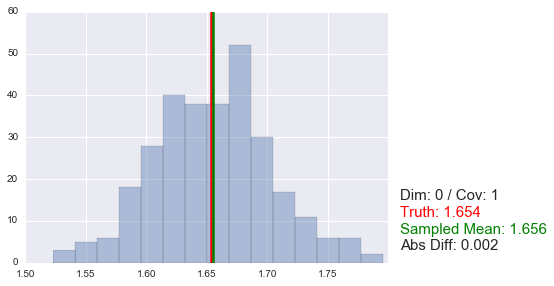

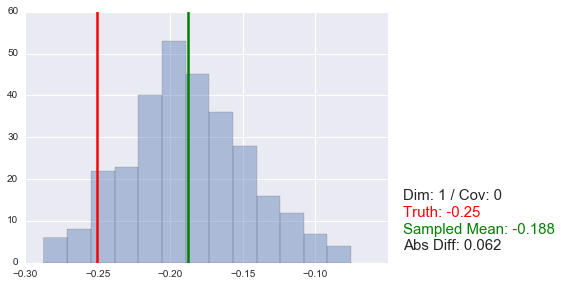

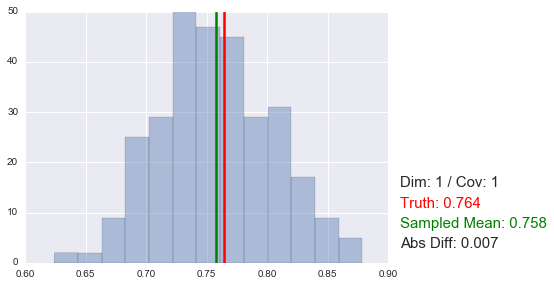

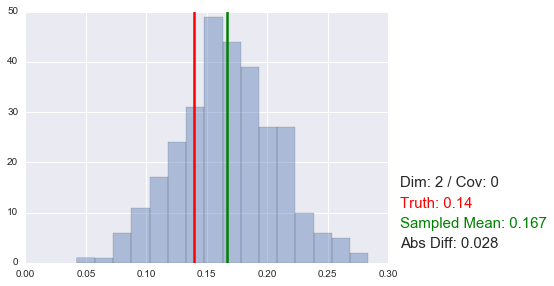

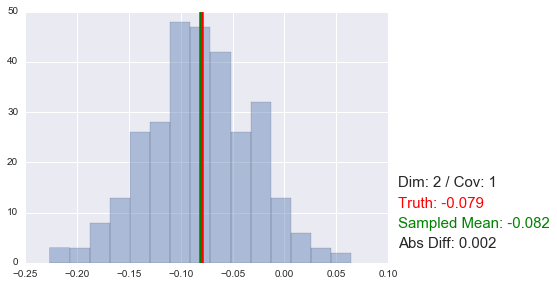

In [12]:
for dim in range(dim_dir):
    for cov in range(num_cov):
        figure(dim, cov)

In [13]:
Lambda_sample # Last Sample

array([[ 2.42061279,  1.61189837],
       [-0.23014525,  0.67591561],
       [ 0.12760432, -0.13235604]])

In [14]:
Lambda # Truth

array([[ 2.44696579,  1.65373908],
       [-0.25035806,  0.76428914],
       [ 0.13954077, -0.07937343]])

In [15]:
Lambda_sampled_mean # Sampled Mean

array([[ 2.49983885,  1.65559507],
       [-0.18800273,  0.75760447],
       [ 0.16721953, -0.08158658]])

In [16]:
Lambda - Lambda_sampled_mean # Truth - Sampled Mean

array([[-0.05287307, -0.00185599],
       [-0.06235532,  0.00668467],
       [-0.02767876,  0.00221315]])